# Опорный пример для выполнения проекта по анализу данных.

## Поиск и выбор набора данных для построения моделей машинного обучения. На основе выбранного набора данных студент должен построить модели машинного обучения для решения или задачи классификации, или задачи регрессии.

В качестве набора данных мы будем использовать набор данных 
по обнаружению присутствия людей в помещении - https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

Эта задача является очень актуальной для создания "умных зданий", 
которые выполняют все требования по кондиционированию воздуха, 
температурным условиям, но при этом экономят электроэнергию в том случае,
если людей в помещении нет.

Датасет состоит из трех файлов:
- datatraining.txt - обучающая выборка
- datatest.txt - тестовая выборка
- datatest2.txt - тестовая выборка большего размера

Каждый файл содержит следующие колонки:
- date - дата-время в формате ГОД-МЕСЯЦ-ДЕНЬ ЧАСЫ:МИНУТЫ:СЕКУНДЫ. Набор данных содержит данные с интервалом измерения в минуту.
- Temperature - температура в градусах Цельсия.
- Humidity - относительная влажность в %.
- Light - освещенность в Люксах.
- CO2 - концентрация углекислого газа в миллионных долях.
- HumidityRatio - величина, производная от температуры и относительной влажности.
- Occupancy - целевой признак датасета. Если в помещении находятся люди то 1, иначе 0.

В рассматриваемом примере будем решать обе задачи - и задачу классификации, и задачу регрессии:
- Для решения **задачи классификации** в качестве целевого признака будем использовать "Occupancy". Поскольку признак содержит только значения 0 и 1, то это задача бинарной классификации.
- Для решения **задачи регрессии** в качестве целевого признака будем использовать "Light".

### Импорт библиотек
Импортируем библиотеки с помощью команды import. Как правило, все команды import размещают в первых ячейках ноутбука.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from gmdhpy import gmdh
%matplotlib inline 
sns.set(style="ticks")

### Загрузка данных

Загрузим файлы датасета в помощью библиотеки Pandas. 

Не смотря на то, что файлы имеют расширение txt они представляют собой данные в формате CSV (https://ru.wikipedia.org/wiki/CSV). Часто в файлах такого формата в качестве разделителей используются символы ",", ";" или табуляция. Поэтому вызывая метод read_csv всегда стоит явно указывать разделитель данных с помощью параметра sep. Чтобы узнать какой разделитель используется в файле его рекомендуется предварительно посмотреть в любом текстовом редакторе.

In [2]:
# Обучающая выборка
original_train = pd.read_csv('data/occupancy_datatraining.txt', sep=",")
# Тестовая выборка (два файла)
original_test_1 = pd.read_csv('data/occupancy_datatest.txt', sep=",")
original_test_2 = pd.read_csv('data/occupancy_datatest2.txt', sep=",")

In [3]:
# Удалим дубликаты записей, если они присутствуют
train = original_train.drop_duplicates()
test_1 = original_test_1.drop_duplicates()
test_2 = original_test_2.drop_duplicates()

## Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

### Основные характеристики датасетов

In [4]:
# Первые 5 строк датасета
train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [5]:
test_1.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [6]:
test_2.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [7]:
# Размер обучающего датасета - 8143 строк, 7 колонок
train.shape, test_1.shape, test_2.shape

((8143, 7), (2665, 7), (9752, 7))

In [8]:
# Список колонок
train.columns

Index(['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy'],
      dtype='object')

In [9]:
# Список колонок с типами данных 
# убедимся что типы данных одинаковы в обучающей и тестовых выборках
train.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

In [10]:
test_1.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

In [11]:
test_2.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

In [12]:
# Проверим наличие пустых значений
train.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [13]:
test_1.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [14]:
test_2.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

**Вывод. Представленный набор данных не содержит пропусков ни в обучающей, ни в тестовой выборках.**

### Построение графиков для понимания структуры данных

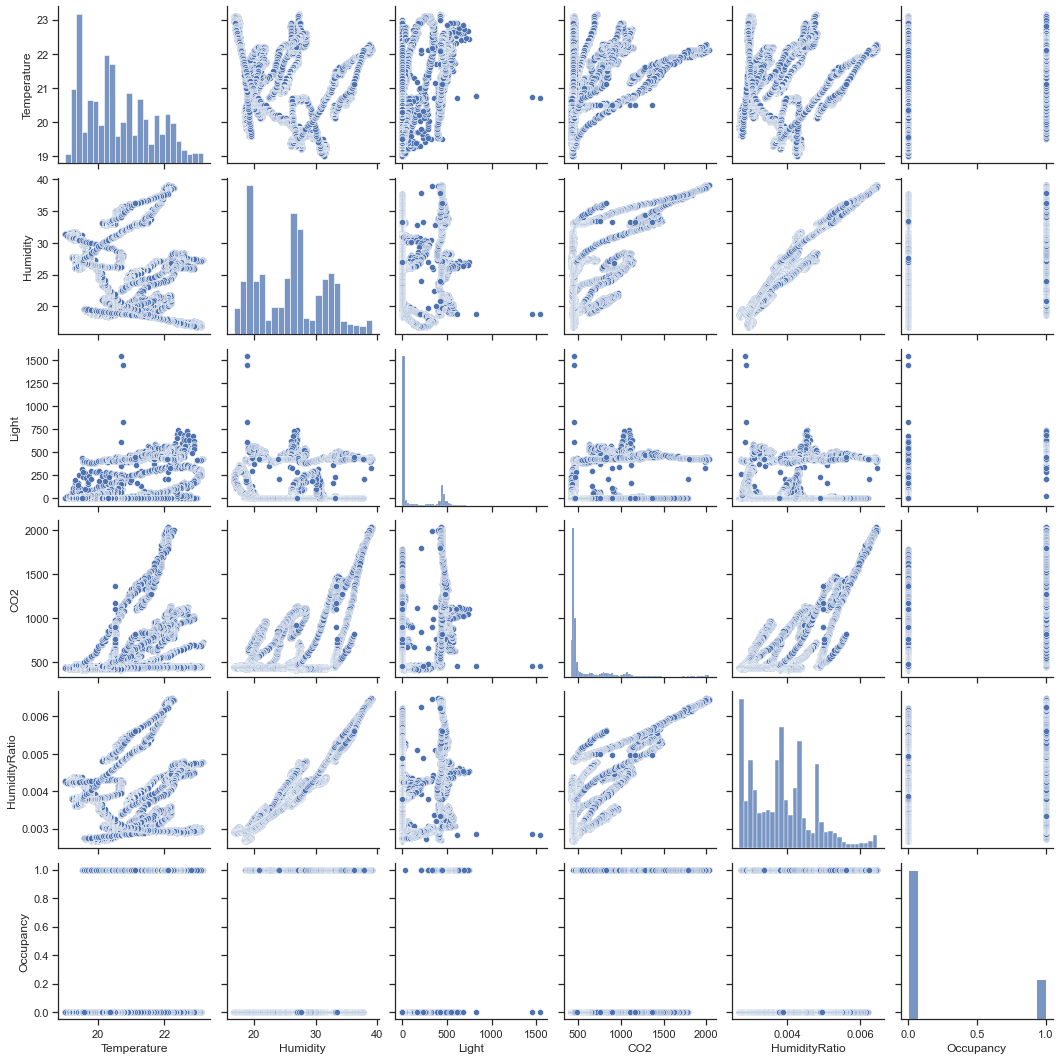

In [15]:
# Парные диаграммы
sns.pairplot(train)

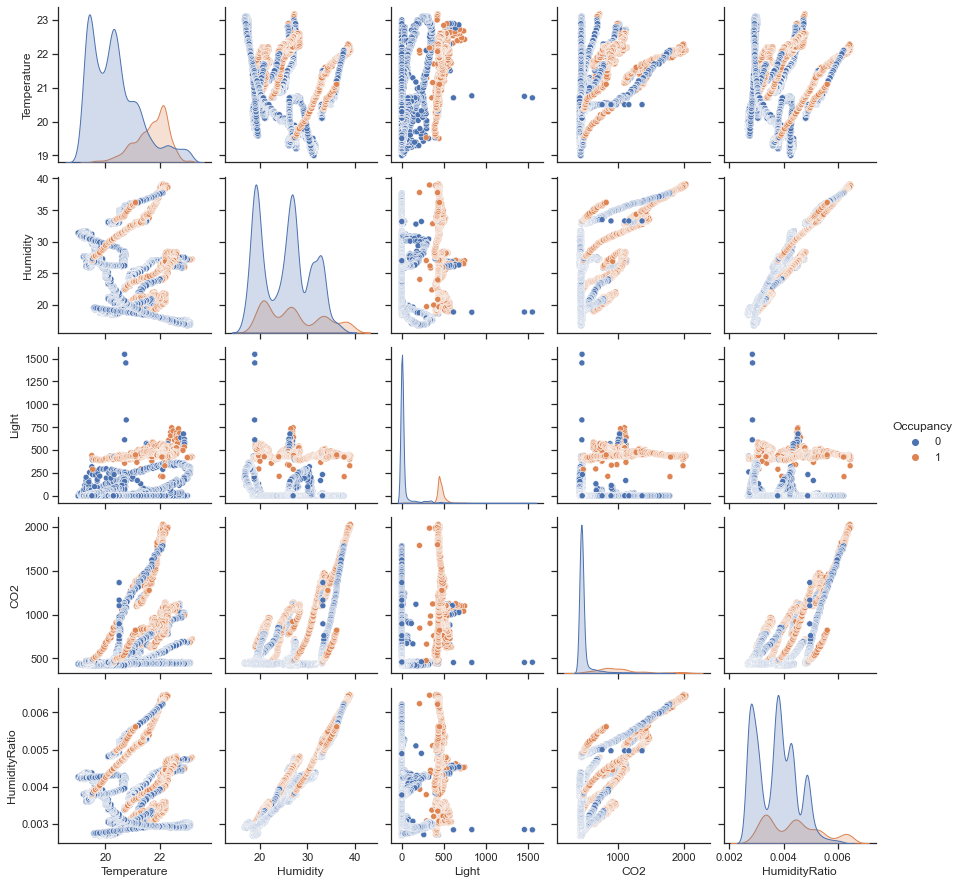

In [16]:
sns.pairplot(train, hue="Occupancy")

In [17]:
# Убедимся, что целевой признак
# для задачи бинарной классификации содержит только 0 и 1
train['Occupancy'].unique()

array([1, 0], dtype=int64)

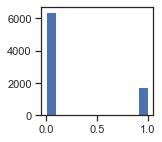

In [18]:
# Оценим дисбаланс классов для Occupancy
fig, ax = plt.subplots(figsize=(2,2)) 
plt.hist(train['Occupancy'])
plt.show()

In [19]:
train['Occupancy'].value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

In [20]:
# посчитаем дисбаланс классов
total = train.shape[0]
class_0, class_1 = train['Occupancy'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 4)*100, round(class_1 / total, 4)*100))

Класс 0 составляет 78.77%, а класс 1 составляет 21.23%.


**Вывод. Дисбаланс классов присутствует, но является приемлемым.**

In [21]:
train.columns

Index(['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy'],
      dtype='object')

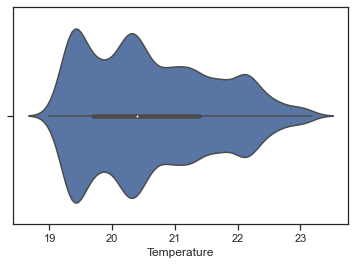

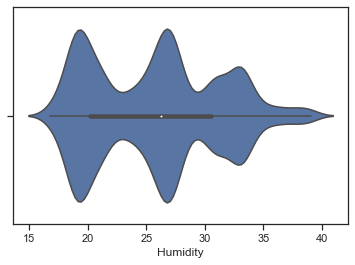

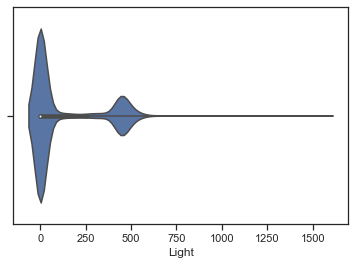

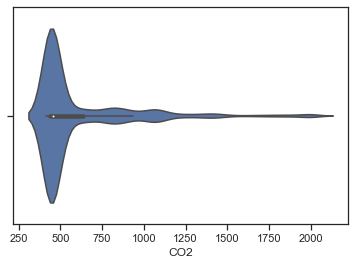

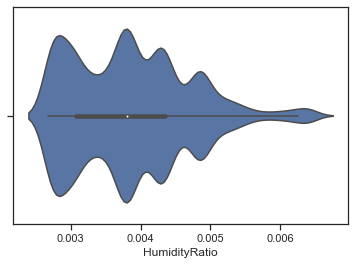

In [22]:
# Скрипичные диаграммы для числовых колонок
for col in ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']:
    sns.violinplot(x=train[col])
    plt.show()

## Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

In [23]:
train.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

Для построения моделей будем использовать все признаки кроме признака date, потому что мы не рассматриваем наши данные как временной ряд.

Категориальные признаки отсутствуют, их кодирования не требуется. Исключением является признак Occupancy, но в представленном датасете  он уже закодирован на основе подхода LabelEncoding.

Вспомогательные признаки для улучшения качества моделей в данном примере мы строить не будем.

Выполним масштабирование данных. Для этого необходимо объединить обучающую и тестовые выборки.

In [24]:
# Создадим вспомогательные колонки, 
# чтобы наборы данных можно было разделить.
train['dataset'] = 'TRAIN'
test_1['dataset'] = 'TEST1'
test_2['dataset'] = 'TEST2'

In [25]:
# Колонки для объединения
join_cols = ['Temperature', 'Humidity', 'Light', 
             'CO2', 'HumidityRatio', 'Occupancy', 'dataset']

In [26]:
data_all = pd.concat([train[join_cols], test_1[join_cols], test_2[join_cols]])

In [27]:
# Проверим корректность объединения
assert data_all.shape[0] == train.shape[0]+test_1.shape[0]+test_2.shape[0]

In [28]:
data_all.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,dataset
1,23.18,27.2720,426.0,721.25,0.004793,1,TRAIN
2,23.15,27.2675,429.5,714.00,0.004783,1,TRAIN
3,23.15,27.2450,426.0,713.50,0.004779,1,TRAIN
4,23.15,27.2000,426.0,708.25,0.004772,1,TRAIN
5,23.10,27.2000,426.0,704.50,0.004757,1,TRAIN


In [29]:
# Числовые колонки для масштабирования
scale_cols = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

In [30]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data_all[scale_cols])

In [31]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data_all[new_col_name] = sc1_data[:,i]

In [32]:
data_all.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,dataset,Temperature_scaled,Humidity_scaled,Light_scaled,CO2_scaled,HumidityRatio_scaled
1,23.18,27.2720,426.0,721.25,0.004793,1,TRAIN,0.772881,0.462624,0.250994,0.185424,0.557318
2,23.15,27.2675,429.5,714.00,0.004783,1,TRAIN,0.767334,0.462426,0.253056,0.181067,0.554807
3,23.15,27.2450,426.0,713.50,0.004779,1,TRAIN,0.767334,0.461437,0.250994,0.180766,0.553761
4,23.15,27.2000,426.0,708.25,0.004772,1,TRAIN,0.767334,0.459459,0.250994,0.177611,0.551669
5,23.10,27.2000,426.0,704.50,0.004757,1,TRAIN,0.758089,0.459459,0.250994,0.175357,0.547851


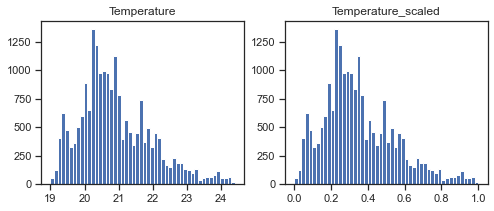

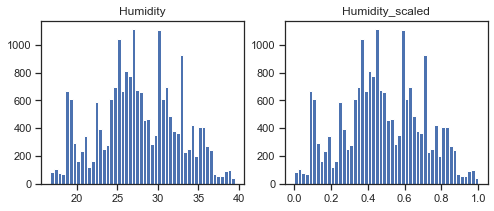

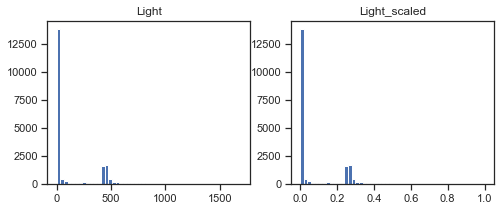

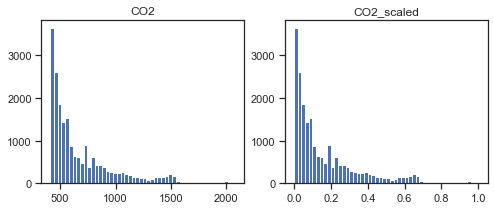

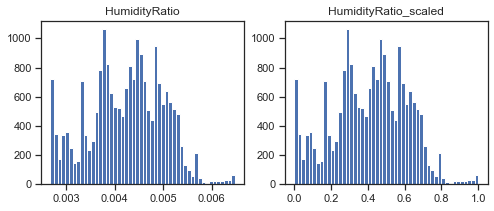

In [33]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data_all[col], 50)
    ax[1].hist(data_all[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

## Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения. 

In [34]:
# Воспользуемся наличием тестовых выборок, 
# включив их в корреляционную матрицу
corr_cols_1 = scale_cols + ['Occupancy']
corr_cols_1

['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']

In [35]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['Occupancy']
corr_cols_2

['Temperature_scaled',
 'Humidity_scaled',
 'Light_scaled',
 'CO2_scaled',
 'HumidityRatio_scaled',
 'Occupancy']

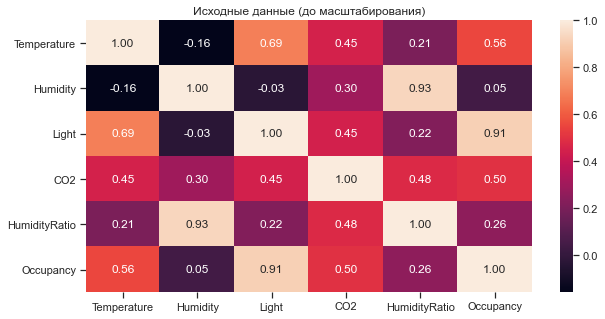

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data_all[corr_cols_1].corr(), annot=True, fmt='.2f')
ax.set_title('Исходные данные (до масштабирования)')
plt.show()

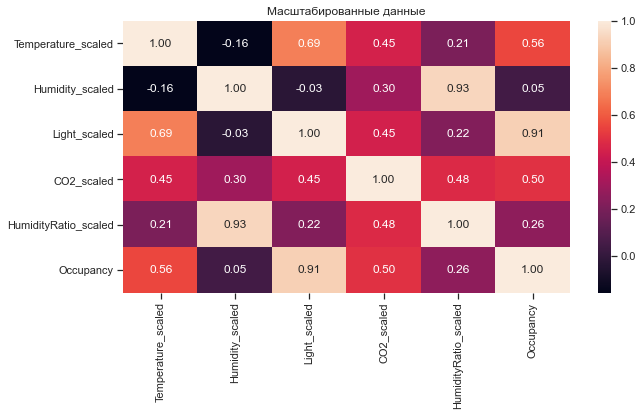

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data_all[corr_cols_2].corr(), annot=True, fmt='.2f')
ax.set_title('Масштабированные данные')
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:

- Корреляционные матрицы для исходных и масштабированных данных совпадают.
- Целевой признак классификации "Occupancy" наиболее сильно коррелирует с освещенностью (0.91), температурой (0.56) и концентрацией углекислого газа (0.5). Эти признаки обязательно следует оставить в модели классификации.
- Целевой признак регрессии "Light" наиболее сильно коррелирует с "Occupancy" (0.91) и температурой (0.69). Эти признаки обязательно следует оставить в модели регрессии.
- Признаки "Humidity" и "HumidityRatio" имеют корреляцию, близкую по модулю к 1, поэтому оба признака не следуют включать в модели. Будем использовать признак "HumidityRatio", так как он лучше чем "Humidity" коррелирует и с целевым признаком классификации, и с целевым признаком регрессии.
- Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой корреляции между исходными признаками и целевым признаком.  На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения. 

## Выбор метрик для последующей оценки качества моделей. 

### В качестве метрик для решения задачи классификации  будем использовать:

Метрики, формируемые на основе матрицы ошибок:

#### Метрика precision:

Можно переводить как точность, но такой перевод совпадает с переводом метрики "accuracy".

$precision = \frac{TP}{TP+FP}$

Доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.

Используется функция [precision_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)

#### Метрика recall (полнота):

$recall = \frac{TP}{TP+FN}$

Доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов.

Используется функция [recall_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)

#### Метрика $F_1$-мера

Для того, чтобы объединить precision и recall в единую метрику используется $F_\beta$-мера, которая вычисляется как среднее гармоническое от precision и recall:

$F_\beta = (1+\beta^2) \cdot \frac{precision \cdot recall}{precision + recall}$

где $\beta$ определяет вес точности в метрике.

На практике чаще всего используют вариант F1-меры (которую часто называют F-мерой) при $\beta=1$:

$F_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$

Для вычисления используется функция [f1_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

#### Метрика ROC AUC

Основана на вычислении следующих характеристик:

$TPR = \frac{TP}{TP+FN}$ - True Positive Rate, откладывается по оси ординат. Совпадает с recall.

$FPR = \frac{FP}{FP+TN}$ - False Positive Rate, откладывается по оси абсцисс. Показывает какую долю из объектов отрицательного класса алгоритм предсказал неверно.

Идеальная ROC-кривая проходит через точки (0,0)-(0,1)-(1,1), то есть через верхний левый угол графика.

Чем сильнее отклоняется кривая от верхнего левого угла графика, тем хуже качество классификации.

В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора.

Для получения ROC AUC используется функция [roc_auc_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

### В качестве метрик для решения задачи регрессии будем использовать:

#### [Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) - средняя абсолютная ошибка

$MAE(y,\hat{y}) = \frac{1}{N} \cdot \sum\limits_{i=1}^N \lvert  y_i - \hat{y_i} \rvert $

где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $N$ - размер тестовой выборки

Чем ближе значение к нулю, тем лучше качество регрессии.

Основная проблема метрики состоит в том, что она не нормирована.

Вычисляется с помощью функции [mean_absolute_error.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)

#### [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) - средняя квадратичная ошибка

$MSE(y,\hat{y}) = \frac{1}{N} \cdot \sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2 $

где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $N$ - размер тестовой выборки

Вычисляется с помощью функции [mean_squared_error.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)

#### [Метрика $R^2$ или коэффициент детерминации](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8) 

$R^2(y,\hat{y}) = 1 - \frac{\sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2}{\sum\limits_{i=1}^N ( y_i - \overline{y_i} )^2} $

где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $N$ - размер тестовой выборки
- $\overline{y_i} = \frac{1}{N} \cdot \sum\limits_{i=1}^N y_i $

Вычисляется с помощью функции [r2_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)

### Сохранение и визуализация метрик

Разработаем класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества.

In [38]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    

## Выбор наиболее подходящих моделей для решения задачи классификации или регрессии.

Для задачи классификации будем использовать следующие модели:
- Логистическая регрессия
- Метод ближайших соседей
- Машина опорных векторов
- Решающее дерево
- Случайный лес
- Градиентный бустинг

Для задачи регрессии будем использовать следующие модели:
- Линейная регрессия
- Метод ближайших соседей
- Машина опорных векторов
- Решающее дерево
- Случайный лес
- Градиентный бустинг

## Формирование обучающей и тестовой выборок на основе исходного набора данных.

In [39]:
# На основе масштабированных данных выделим 
# обучающую и тестовую выборки с помощью фильтра
train_data_all = data_all[data_all['dataset']=='TRAIN']
test_data_all = data_all[data_all['dataset']=='TEST1']
train_data_all.shape, test_data_all.shape

((8143, 12), (2665, 12))

In [40]:
# Признаки для задачи классификации
task_clas_cols = ['Temperature_scaled', 'Light_scaled', 
                  'CO2_scaled', 'HumidityRatio_scaled']

In [41]:
# Выборки для задачи классификации
clas_X_train = train_data_all[task_clas_cols]
clas_X_test = test_data_all[task_clas_cols]
clas_Y_train = train_data_all['Occupancy']
clas_Y_test = test_data_all['Occupancy']
clas_X_train.shape, clas_X_test.shape, clas_Y_train.shape, clas_Y_test.shape

((8143, 4), (2665, 4), (8143,), (2665,))

In [42]:
# Признаки для задачи регресии
task_regr_cols = ['Occupancy', 'Temperature_scaled',  
                  'CO2_scaled', 'HumidityRatio_scaled']

In [43]:
# Выборки для задачи регресии
regr_X_train = train_data_all[task_regr_cols]
regr_X_test = test_data_all[task_regr_cols]
regr_Y_train = train_data_all['Light']
regr_Y_test = test_data_all['Light']
regr_X_train.shape, regr_X_test.shape, regr_Y_train.shape, regr_Y_test.shape

((8143, 4), (2665, 4), (8143,), (2665,))

## Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

### Решение задачи классификации

In [44]:
# Модели
clas_models = {'LogR': LogisticRegression(), 
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'SVC':SVC(probability=True),
               'Tree':DecisionTreeClassifier(),
               'RF':RandomForestClassifier(),
               'GB':GradientBoostingClassifier()}

In [45]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [46]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, ax, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    #plt.figure()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_xlim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")

In [47]:
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(clas_X_train, clas_Y_train)
    # Предсказание значений
    Y_pred = model.predict(clas_X_test)
    # Предсказание вероятности класса "1" для roc auc
    Y_pred_proba_temp = model.predict_proba(clas_X_test)
    Y_pred_proba = Y_pred_proba_temp[:,1]
    
    precision = precision_score(clas_Y_test.values, Y_pred)
    recall = recall_score(clas_Y_test.values, Y_pred)
    f1 = f1_score(clas_Y_test.values, Y_pred)
    roc_auc = roc_auc_score(clas_Y_test.values, Y_pred_proba)
    
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    fig, ax = plt.subplots(ncols=2, figsize=(10,5))    
    draw_roc_curve(clas_Y_test.values, Y_pred_proba, ax[0])
    plot_confusion_matrix(model, clas_X_test, clas_Y_test.values, ax=ax[1],
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    fig.suptitle(model_name)
    plt.show()

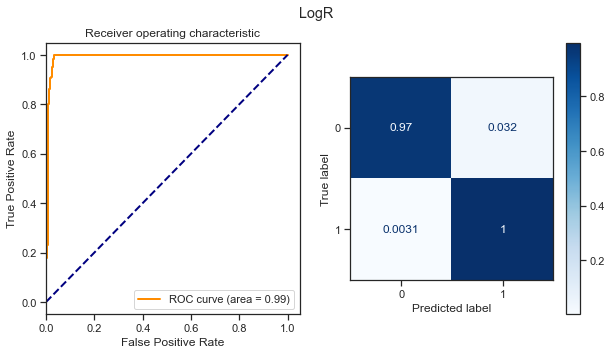

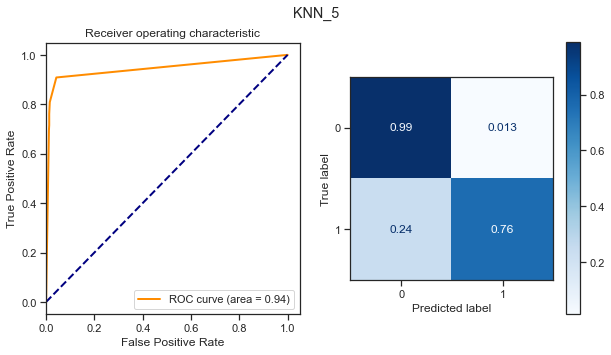

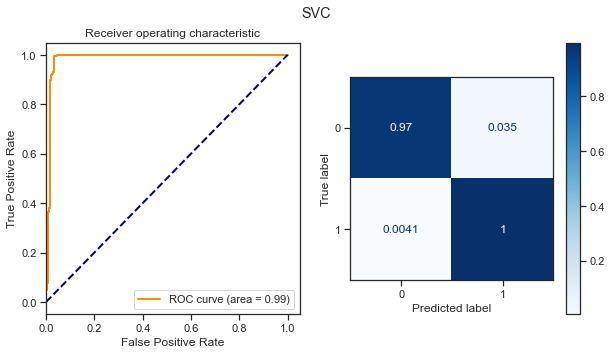

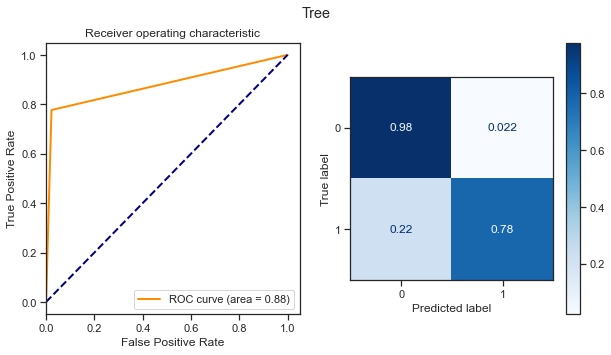

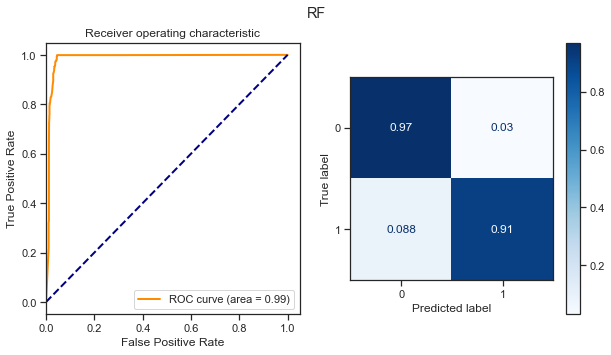

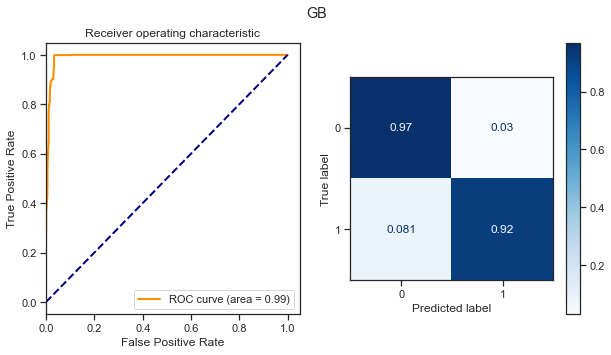

In [48]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

### Решение задачи регрессии

In [49]:
# Модели
regr_models = {'LR': LinearRegression(), 
               'KNN_5':KNeighborsRegressor(n_neighbors=5),
               'SVR':SVR(),
               'Tree':DecisionTreeRegressor(),
               'RF':RandomForestRegressor(),
               'GB':GradientBoostingRegressor()}

In [50]:
# Сохранение метрик
regrMetricLogger = MetricLogger()

In [51]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(regr_X_train, regr_Y_train)
    Y_pred = model.predict(regr_X_test)
    
    mae = mean_absolute_error(regr_Y_test, Y_pred)
    mse = mean_squared_error(regr_Y_test, Y_pred)
    r2 = r2_score(regr_Y_test, Y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('{} \t MAE={}, MSE={}, R2={}'.format(
        model_name, round(mae, 3), round(mse, 3), round(r2, 3)))

In [52]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

LR 	 MAE=61.148, MSE=7884.694, R2=0.874
KNN_5 	 MAE=55.189, MSE=16598.128, R2=0.735
SVR 	 MAE=41.59, MSE=10397.455, R2=0.834
Tree 	 MAE=40.514, MSE=12256.071, R2=0.804
RF 	 MAE=42.973, MSE=9529.169, R2=0.848
GB 	 MAE=45.188, MSE=8037.037, R2=0.872


## Подбор гиперпараметров для выбранных моделей. Рекомендуется использовать методы кросс-валидации. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.

### Пример для задачи классификации

In [53]:
clas_X_train.shape

(8143, 4)

In [54]:
n_range_list = list(range(0,1250,50))
n_range_list[0] = 1

In [55]:
n_range = np.array(n_range_list)
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([   1,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
          550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
         1100, 1150, 1200])}]

In [56]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='roc_auc')
clf_gs.fit(clas_X_train, clas_Y_train)

Wall time: 32.4 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([   1,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150, 1200])}],
             scoring='roc_auc')

In [57]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=1150)

In [58]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 1150}

In [59]:
clf_gs_best_params_txt = str(clf_gs.best_params_['n_neighbors'])
clf_gs_best_params_txt

'1150'

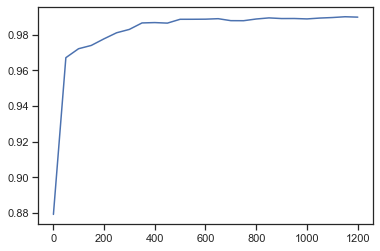

In [60]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

### Пример для задачи регрессии

In [61]:
n_range = np.array(range(1,2000,100))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([   1,  101,  201,  301,  401,  501,  601,  701,  801,  901, 1001,
         1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901])}]

In [62]:
%%time
regr_gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(regr_X_train, regr_Y_train)

Wall time: 33.4 s


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([   1,  101,  201,  301,  401,  501,  601,  701,  801,  901, 1001,
       1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901])}],
             scoring='neg_mean_squared_error')

In [63]:
# Лучшая модель
regr_gs.best_estimator_

KNeighborsRegressor(n_neighbors=801)

In [64]:
# Лучшее значение параметров
regr_gs.best_params_

{'n_neighbors': 801}

In [65]:
regr_gs_best_params_txt = str(regr_gs.best_params_['n_neighbors'])
regr_gs_best_params_txt

'801'

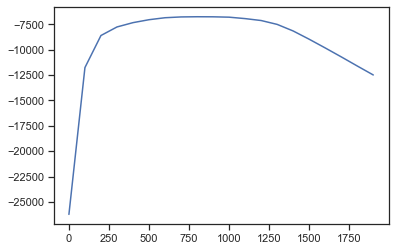

In [66]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, regr_gs.cv_results_['mean_test_score'])

## Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей.

### Решение задачи классификации

In [67]:
clas_models_grid = {'KNN_5':KNeighborsClassifier(n_neighbors=5), 
                    str('KNN_' + clf_gs_best_params_txt):clf_gs.best_estimator_}

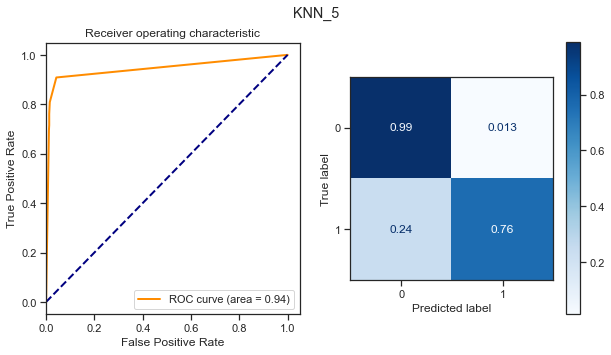

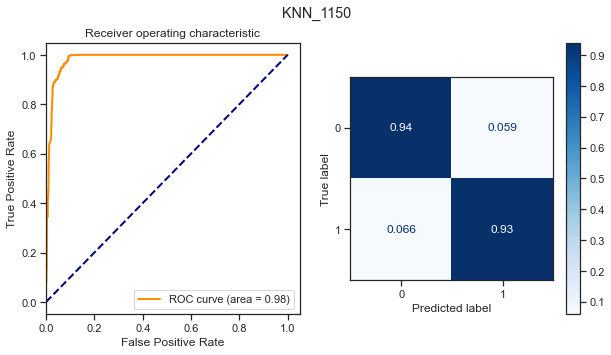

In [68]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

### Решение задачи регрессии

In [69]:
regr_models_grid = {'KNN_5':KNeighborsRegressor(n_neighbors=5), 
                    str('KNN_'+regr_gs_best_params_txt):regr_gs.best_estimator_}

In [70]:
for model_name, model in regr_models_grid.items():
    regr_train_model(model_name, model, regrMetricLogger)

KNN_5 	 MAE=55.189, MSE=16598.128, R2=0.735
KNN_801 	 MAE=41.391, MSE=8404.259, R2=0.866


## Формирование выводов о качестве построенных моделей на основе выбранных метрик. Результаты сравнения качества рекомендуется отобразить в виде графиков и сделать выводы в форме текстового описания. Рекомендуется построение графиков обучения и валидации, влияния значений гиперпарметров на качество моделей и т.д.

### Решение задачи классификации

In [71]:
# Метрики качества модели
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1', 'roc_auc'], dtype=object)

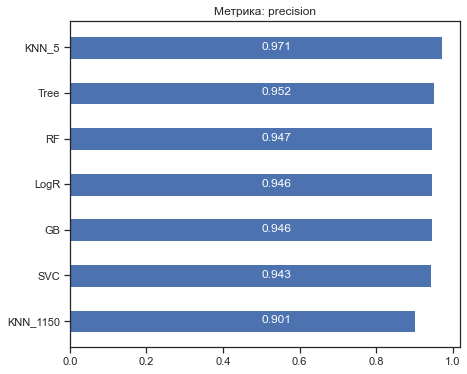

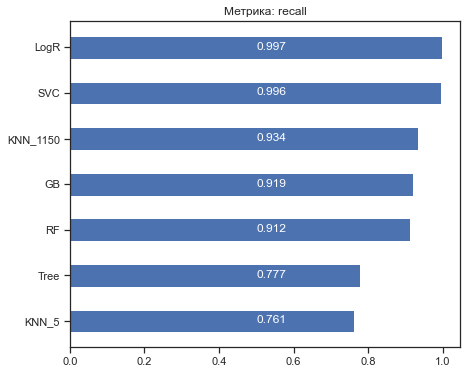

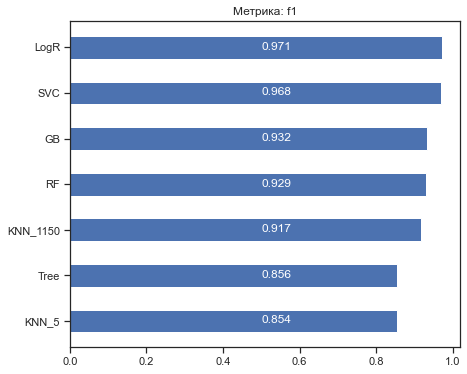

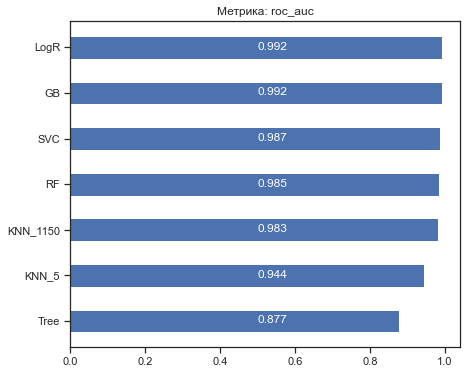

In [72]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

**Вывод: на основании трех метрик из четырех используемых,  лучшей оказалась модель логистической регрессии.**

### Решение задачи регрессии

In [73]:
# Метрики качества модели
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MSE', 'R2'], dtype=object)

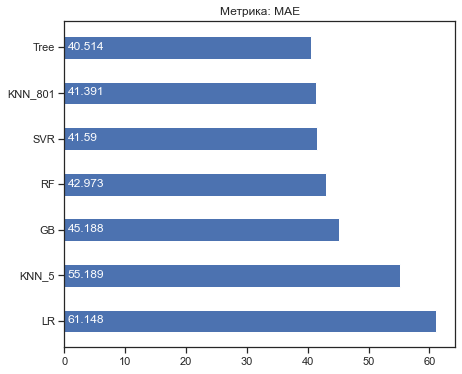

In [74]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 6))

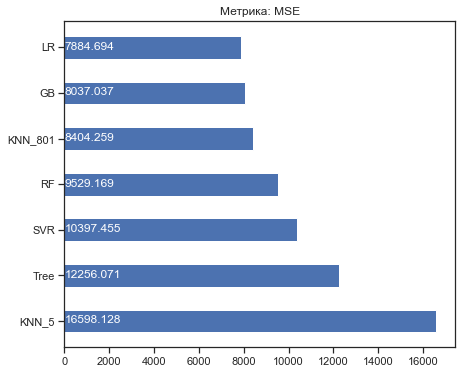

In [75]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', ascending=False, figsize=(7, 6))

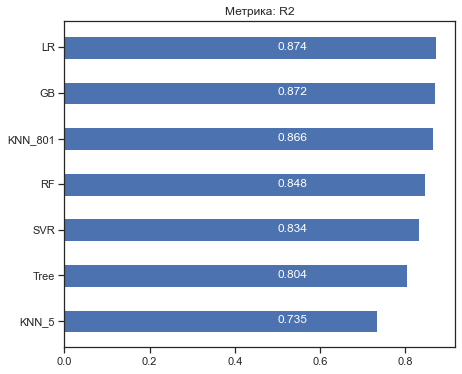

In [76]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2', ascending=True, figsize=(7, 6))

**Вывод: лучшими оказались модели на основе линейной регресии и решающего дерева. При отдельных запусках вместо решающего дерева оказывается лучшей модель случайного леса.**